In [1]:
import os
from data.source.pg_experiment import get_pg_experiment_dataframe
import polars as pl

from models.SimplifiedLightweightCNN import SimplifiedLightweightCNN
%load_ext autoreload
%autoreload 1
%aimport models.SimplifiedLightweightCNN
from models.SimpleCNN_v2 import train, evaluate
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from path import RESULT_DIRECTORY
import wandb
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
df_pron_v1, _ = get_pg_experiment_dataframe(extension=".ogg", assesment_version="v1")
df_pron_v2, _ = get_pg_experiment_dataframe(extension=".ogg", assesment_version="v2")
df_pron_v1 = df_pron_v1.filter((pl.col("stage") == 1))
df_pron_v2 = df_pron_v2.filter((pl.col("stage") == 1))
print(f"Number of samples: {df_pron_v1.shape, df_pron_v2.shape}")
df_pron_v2.head()

get_pg_experiment_dataset(): WARNING, Dropped 2 rows with missing files
get_pg_experiment_dataset(): WARNING, Dropped 2 rows with missing files
Number of samples: ((6016, 8), (5855, 8))


id_student,value,word_id,rec_path,stage,univ,gender,mother
i64,str,str,str,i32,str,str,str
1534,"""1""","""a0""","""/home/kamil2002/Mandarin_Pronu…",1,"""CLES_UMK5""","""f""","""polish"""
1454,"""0""","""a0""","""/home/kamil2002/Mandarin_Pronu…",1,"""MBI_2024""","""m""","""polish"""
592,"""1""","""a0""","""/home/kamil2002/Mandarin_Pronu…",1,"""MBI_2023""","""m""","""polish"""
527,"""1""","""a0""","""/home/kamil2002/Mandarin_Pronu…",1,"""MBI_2023""","""m""","""polish"""
1297,"""0""","""a0""","""/home/kamil2002/Mandarin_Pronu…",1,"""MBI_2024""","""m""","""polish"""


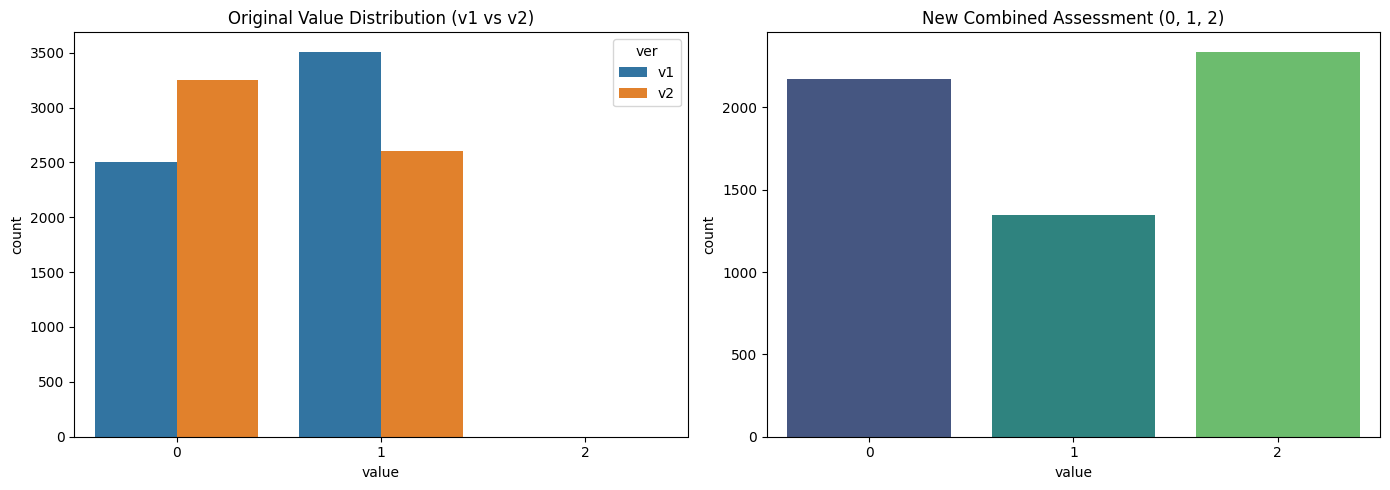

Intersection size: 5855


In [3]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Alignment / Joining
join_key = "rec_path" 

# Inner join ensures only samples existing in both versions are kept
df_joined = df_pron_v1.join(
    df_pron_v2.select([join_key, "value"]), 
    on=join_key, 
    how="inner", 
    suffix="_v2"
)

# Using Int8 for maximum memory efficiency (0, 1, 2 fits easily)
df_joined = df_joined.with_columns([
    pl.struct("word_id").rank("dense").alias("word_id"),
    pl.col("value").cast(pl.Int8),
    pl.col("value_v2").cast(pl.Int8),
])

# 2. Comparative Score Analysis & Column Cleanup
# We calculate the final value and drop the v2 helper column in one chain
df_combined = df_joined.with_columns(
    value = pl.when(pl.col("value").replace(1, 2) != pl.col("value_v2").replace(1, 2))
            .then(pl.lit(1, dtype=pl.Int8))
            .otherwise(pl.col("value").replace(1, 2))
).drop("value_v2")

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Score Distribution (Originals)
dist_data = pl.concat([
    df_pron_v1.select(pl.col("value").cast(pl.Utf8)).with_columns(pl.lit("v1").alias("ver")),
    df_pron_v2.select(pl.col("value").cast(pl.Utf8)).with_columns(pl.lit("v2").alias("ver"))
]).to_pandas()

sns.countplot(data=dist_data, x="value", hue="ver", ax=axes[0], order=["0", "1", "2"])
axes[0].set_title("Original Value Distribution (v1 vs v2)")

# Plot 2: New Combined Distribution
combined_pd = df_combined.select(pl.col("value").cast(pl.Utf8)).to_pandas()
sns.countplot(data=combined_pd, x="value", hue="value", palette="viridis", ax=axes[1], order=["0", "1", "2"], legend=False)
axes[1].set_title("New Combined Assessment (0, 1, 2)")

plt.tight_layout()
plt.show()

# 3. Final Output
print(f"Intersection size: {df_combined.shape[0]}")

# Set the final variable as requested
dataframe = df_combined
N_WORDS = dataframe.select(pl.col("word_id").n_unique()).item()

In [4]:
import polars as pl
import numpy as np
from typing import Tuple

def stratified_split(df: pl.DataFrame, label_col: str, train_frac=0.8, val_frac=0.1, seed=42) -> Tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
    classes = df.select(label_col).unique().to_series()
    train_rows, val_rows, test_rows = [], [], []

    rng = np.random.RandomState(seed)

    for cls in classes:
        class_df = df.filter(pl.col(label_col) == cls)
        n = class_df.height
        indices = rng.permutation(n)

        train_end = int(train_frac * n)
        val_end = int((train_frac + val_frac) * n)

        train_rows.append(class_df[indices[:train_end]])
        val_rows.append(class_df[indices[train_end:val_end]])
        test_rows.append(class_df[indices[val_end:]])

    train_df = pl.concat(train_rows)
    val_df = pl.concat(val_rows)
    test_df = pl.concat(test_rows)

    return train_df, val_df, test_df


In [ ]:
from typing import Callable

from polars import DataFrame
from dataset import Cast, TorchDataset
from develop import reload_function, reload_module
import pytorch_dataloader
reload_module(pytorch_dataloader)
from pytorch_dataloader import ReshapeCollate, build_collate_fn, PaddingCollate, DefaultCollate
from functools import partial

from transformation import Channels, RMSEnergy, TorchVadLogMelSpec, TorchVadMFCC, ZeroCrossingRate

reload_function(TorchVadMFCC)

TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2
TEST_SPLIT = 1 - TRAIN_SPLIT - VAL_SPLIT
train_pl, val_pl, test_pl = stratified_split(dataframe, label_col="value", train_frac=TRAIN_SPLIT, val_frac=VAL_SPLIT)

to_dataset: Callable[[DataFrame], TorchDataset] = lambda dataframe: TorchDataset(
    Cast(dataframe.get_column("rec_path"), Channels("stack","multiply")(
            TorchVadMFCC(delta=0),
        )),
    Cast(dataframe.get_column("rec_path"), Channels("cat","multiply")(
            ZeroCrossingRate(),
            RMSEnergy(),
        )),
    # Use native arithmetic before tensor creation
    Cast(dataframe.get_column("word_id"), lambda x: torch.tensor(x, dtype=torch.long) - 1),
    # Change .float() to .long() for classification labels
    Cast(dataframe.get_column("value"), lambda x: torch.tensor(x, dtype=torch.long)),
)

collate_fn = build_collate_fn(
    PaddingCollate(mode="SET_MAX_LEN", max_len=80, pad_dim=2),
    PaddingCollate(mode="SET_MAX_LEN", max_len=160, pad_dim=1),
    DefaultCollate(),
    DefaultCollate(),
)
dataset_train = to_dataset(train_pl)
dataset_val = to_dataset(val_pl)
dataset_test = to_dataset(test_pl)



In [14]:
def print_split_distribution(df, name):
    dist = df.group_by("value").count().sort("value")
    total = dist["count"].sum()
    
    print(f"\n--- {name} Split Distribution ---")
    for row in dist.iter_rows(named=True):
        val = row["value"]
        count = row["count"]
        percent = (count / total) * 100
        print(f"Class {val}: {count} samples ({percent:.2f}%)")

# Execute printouts
print_split_distribution(train_pl, "TRAIN")
print_split_distribution(val_pl, "VALIDATION")
print_split_distribution(test_pl, "TEST")


--- TRAIN Split Distribution ---
Class 0: 1303 samples (37.10%)
Class 1: 806 samples (22.95%)
Class 2: 1403 samples (39.95%)

--- VALIDATION Split Distribution ---
Class 0: 434 samples (37.06%)
Class 1: 269 samples (22.97%)
Class 2: 468 samples (39.97%)

--- TEST Split Distribution ---
Class 0: 435 samples (37.12%)
Class 1: 269 samples (22.95%)
Class 2: 468 samples (39.93%)


/tmp/ipykernel_14738/1743399432.py:2: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  dist = df.group_by("value").count().sort("value")


In [6]:
from pytorch_dataloader import MemoryLoadedDataLoader
from os import name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#note, if you are using Windows you MUST set `num_workers=0` - TL;DT multithreading DON'T work in notebooks because Windows DON'T have `fork()`
num_workers = 0 if name == "nt" else 4
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, persistent_workers=(num_workers > 0))
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=num_workers, persistent_workers=(num_workers > 0))
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=num_workers, persistent_workers=(num_workers > 0))

for x in next(iter(train_loader)):
    print(x.shape)

/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/500/a5.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/664/a9.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/345/a0.ogg has no speech segments, using full waveform
torch.Size([16, 1, 40, 80])
torch.Size([16, 2, 160])
torch.Size([16])
torch.Size([16])


/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/493/a6.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/761/a3.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1336/a10.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/944/a2.ogg 
has no speech segments, using full waveform/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/550/a5.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/61/a9.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/sourc

In [7]:
train_loader = MemoryLoadedDataLoader(train_loader, device=device)
print("Loaded train loader into memory")
val_loader = MemoryLoadedDataLoader(val_loader, device=device)
print("Loaded validation loader into memory")

Loaded train loader into memory
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1293/a5.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/761/a4.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/587/a0.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1536/a1.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/944/a0.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1536/a7.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciat

In [18]:
from models.FusionCNN import ContextFusionCNN
reload_function(ContextFusionCNN)
model = ContextFusionCNN(1,2, num_classes=3, num_words=N_WORDS, dropout_rate=0.3)

In [9]:
wandb.login(key="df5cbdf4ec56162d09c57d7b456e83e24dbd24e1")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/kamil2002/.netrc
wandb: Currently logged in as: fischbach-kamil (fischbach-kamil-pg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [19]:
# Model variables definition.
pth = "ContextFusionCNN.pth"
lr = 1e-4  # Reduce from 1e-3
epochs = 30
model = model.to(device)
reload_function(train)
reload_function(evaluate)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # Add L2 regularization
# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)
weights = torch.tensor([1.0, 1.5, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Start a new wandb run to track this script.
name = "CFCNN(3) with labels [0,1,2]"
run = wandb.init(
    name=name,
    config={
        "Name": 'ContextFusionCNN',
        "learning_rate": lr,
        "optimizer": "Adam",
        "criterion": "CrossEntropyLoss",
        "architecture": "ContextFusionCNN",
        "architecture_details": str(model),
        "dataset": "Stage-I",
        "train_val_test(%)": f'{TRAIN_SPLIT}-{VAL_SPLIT}-{TEST_SPLIT}',
        "epochs": epochs,
    },
)

# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    # Update learning rate
    scheduler.step(val_loss)
    # Logging the metadata for each epoch so that the charts can be generated on the dashboard
    run.log({"train_acc": train_acc, "train_loss": train_loss, "val_acc": val_acc, "val_loss": val_loss, })
    print(
        f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Saving the model to pth and adding it to the artifacts of the run, there is 5GB of memory on wandb, so we should be fine.
torch.save(model.state_dict(), os.path.join(RESULT_DIRECTORY, pth))
artifact = wandb.Artifact("CFCNN-3labels", type="model")
artifact.add_file(os.path.join(RESULT_DIRECTORY, pth))
run.log_artifact(artifact)

# Finish the run so it gets sent to the remote. You can discover the run right after that on the dashboard.
run.finish()


Epoch 1, Train Loss: 1.0923, Train Acc: 0.4063, Val Loss: 1.0729, Val Acc: 0.4159
Epoch 2, Train Loss: 1.0827, Train Acc: 0.4314, Val Loss: 1.0610, Val Acc: 0.4338
Epoch 3, Train Loss: 1.0689, Train Acc: 0.4499, Val Loss: 1.0441, Val Acc: 0.4509
Epoch 4, Train Loss: 1.0556, Train Acc: 0.4804, Val Loss: 1.0264, Val Acc: 0.4825
Epoch 5, Train Loss: 1.0424, Train Acc: 0.4949, Val Loss: 1.0113, Val Acc: 0.5192
Epoch 6, Train Loss: 1.0266, Train Acc: 0.5117, Val Loss: 0.9989, Val Acc: 0.5209
Epoch 7, Train Loss: 1.0144, Train Acc: 0.5117, Val Loss: 0.9865, Val Acc: 0.5568
Epoch 8, Train Loss: 1.0031, Train Acc: 0.5290, Val Loss: 0.9794, Val Acc: 0.5517
Epoch 9, Train Loss: 0.9958, Train Acc: 0.5336, Val Loss: 0.9741, Val Acc: 0.5594
Epoch 10, Train Loss: 0.9991, Train Acc: 0.5273, Val Loss: 0.9724, Val Acc: 0.5491
Epoch 11, Train Loss: 0.9976, Train Acc: 0.5305, Val Loss: 0.9717, Val Acc: 0.5551
Epoch 12, Train Loss: 0.9923, Train Acc: 0.5382, Val Loss: 0.9665, Val Acc: 0.5576
Epoch 13, Tra

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


train_acc,▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇██▇███▇██████
train_loss,██▇▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▂▃▄▆▆█████████▇██▇▇▇▇▇▇▇▇▇▇▇▆
val_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.54841
train_loss,0.95637
val_acc,0.52775
val_loss,0.94827


In [11]:
test_loader = MemoryLoadedDataLoader(test_loader, device=device)
print("Loaded test loader into memory")

/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/550/a10.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/1293/a3.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/668/a6.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/378/a4.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/677/a4.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/source/pg_dataset/recordings/stageI/373/a10.ogg has no speech segments, using full waveform
/home/kamil2002/Mandarin_Pronunciation_Recognition_Project/data/sou

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

# 1. Collect labels and predictions
y_true = np.concatenate([labels.cpu().numpy() for *_, labels in test_loader])
y_pred = np.concatenate([model(*[s.to(device) for s in specs]).argmax(1).cpu().numpy() 
                         for *specs, _ in test_loader])

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels_text = ["Wrong(0)", "Partly(1)", "Corr(2)"]

print("-" * 45)
print(f"FINAL TEST RESULTS | Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")
print("-" * 45)

# 3. Enhanced Text-Based Confusion Matrix
print("\n--- CONFUSION MATRIX ---")
print("          Predicted Labels")
print("          0      1      2")
print("        ------------------")
for i, row in enumerate(cm):
    row_formatted = "".join([f" [{val:^4}]" if i==j else f"  {val:^4} " for j, val in enumerate(row)])
    print(f"True {i}|{row_formatted}  <-- {labels_text[i]}")
print("        ------------------")

# 4. Detailed Metrics Table
print("\n--- PERFORMANCE METRICS ---")
print(f"{'Class':<12} | {'Prec.':<7} | {'Recall':<7} | {'F1-Score':<8}")
print("-" * 45)

# Manual calculation for transparency
for i in range(len(labels_text)):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{labels_text[i]:<12} | {precision:<7.2%} | {recall:<7.2%} | {f1:<8.2%}")

print("-" * 45)
print("Macro Average F1-Score: ", f"{np.mean([cm[i,i]/cm[i,:].sum() if cm[i,:].sum()>0 else 0 for i in range(3)]):.2%}")

---------------------------------------------
FINAL TEST RESULTS | Loss: 0.9424 | Acc: 0.5452
---------------------------------------------

--- CONFUSION MATRIX ---
          Predicted Labels
          0      1      2
        ------------------
True 0| [241 ]   98     96    <-- Wrong(0)
True 1|  107   [ 73 ]   89    <-- Partly(1)
True 2|   84     59   [325 ]  <-- Corr(2)
        ------------------

--- PERFORMANCE METRICS ---
Class        | Prec.   | Recall  | F1-Score
---------------------------------------------
Wrong(0)     | 55.79%  | 55.40%  | 55.59%  
Partly(1)    | 31.74%  | 27.14%  | 29.26%  
Corr(2)      | 63.73%  | 69.44%  | 66.46%  
---------------------------------------------
Macro Average F1-Score:  50.66%
